#### **Import Libraries**

In [1]:
from typing import Tuple, Sequence
import jax 
import jax.numpy as jnp
from jax import Array
import flax.linen as nn 
from functools import partial 
from tqdm import tqdm 
import optax 
from einops import rearrange, repeat
from diffrax import diffeqsolve, ODETerm, Dopri5
from tqdm import tqdm 
from rfp import MLP, Model, ModelParams
from rfp.losses import Supervised_Loss, mse, Cluster_Loss
from rfp.train import Trainer

/Users/ppower1/.pyenv/versions/3.10.0/envs/evict_env/lib/python3.10/site-packages/equinox/_ad.py:801: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


#### **Path**

In [2]:
figure_folders = './../../../rfp_paper/figures/'

#### **Set Up Plotting**

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/Users/ppower1/Documents/GitHub/rfp/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-SemiBold.ttf


#### **Data Hyperparameters**

In [4]:
n = 100             
d = 1             
c = 10
k = 7           
init_key = jax.random.PRNGKey(0)
nodes = 64
inner_lr = 1e-3
lr = 1e-3
epochs = 1000 
inner_epochs = 5
simulations = 100
reg_value = .9

#### **Value to Key**

In [5]:
def value_to_key(value: float) -> jax.random.PRNGKey:
    # Ensure value is in the range [0, 1]
    
    # Scale value to the range of PRNG key integers
    max_int = jnp.iinfo(jnp.int32).max
    scaled_value = jnp.array(value * max_int, dtype=jnp.int32)
    
    # Create a new key using the scaled value
    key = jax.random.PRNGKey(scaled_value)
    
    return key

#### **Generate Conditional Expectation Functions**

In [6]:
class SimpleMLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = nn.Dense(feat, name=f'layers_{i}')(x)
      if i != len(self.features) - 1:
        x = nn.hard_swish(x)
    return x
base_model = SimpleMLP( [nodes, nodes, 1])

def gen_outcome(params_key, features):
    a, b, c = jax.random.normal(params_key, shape=(3,))
    f = lambda x: a*x**2 + b*x + c
    return jax.vmap(f)(features)

def gen_outcome(params_key, features):
    k1, k2 = jax.random.split(params_key)
    mus = jax.random.normal(k1, shape=(10,))
    alphas = jax.random.normal(k2, shape=(10,))
    f = lambda x: jnp.dot(partial(jax.scipy.stats.norm.pdf, x)(mus), alphas)
    ys = jax.vmap(f)(features)
    return ys.reshape(-1,1)

def gen_outcome(params_key, features):
    a = jax.random.normal(params_key, shape=(1,))
    f = lambda x: a*x
    return jax.vmap(f)(features)



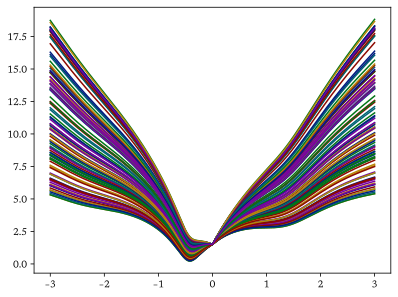

In [7]:
def gen_outcome(params_key, features):
    
    def main_effect(x, p):
      return jnp.log(x**2 + 1.0 + jnp.sin(x*3.0)) + 1.5 + jnp.abs(x)*p
    p = jax.random.uniform(params_key, minval=0.5, maxval=5., shape=(1,))
    return jax.vmap(partial(main_effect, p=p))(features)


key = jax.random.PRNGKey(0)
for _ in range(100):
    key, k1, k2 = jax.random.split(key, 3)
    xs = jnp.linspace(-3., 3., 1000)
    ys = gen_outcome(k2, xs)
    idx = jnp.argsort(xs.reshape(-1,))
    plt.plot(xs[idx], ys[idx])
plt.show()

#### **Sample Data**

In [8]:
scaling_factor = 0.1
def sample(key, n, d):
    k1, k2, k3 = jax.random.split(key, 3)
    cluster_feature = jax.random.uniform(k2)
    params_key = value_to_key(cluster_feature)
    means = jax.random.uniform(k1, shape=(d,), minval=-2., maxval=2.) #jnp.zeros(shape=(d,))#
    cov = jnp.eye(d) * scaling_factor
    xs = jax.random.multivariate_normal(k2, mean=means, cov=cov, shape=(n,))
    features = xs 
    outcomes = gen_outcome(params_key, features)
    return features, outcomes

In [9]:
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(mse, model.fwd_pass) #*** I am not sure this is correct***
standard_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)


inner_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=inner_lr), inner_epochs)
cluster_loss_train = Cluster_Loss(inner_yuri, reg_value)
cluster_loss_val = Cluster_Loss(inner_yuri, 0.0)
cluster_yuri = Trainer(cluster_loss_train,   optax.sgd(learning_rate=lr, momentum=0.9), epochs, val_loss_fn=cluster_loss_val)

Final Activation Function: <function <lambda> at 0x2b3cbf400>


In [10]:
def get_data_params(key, n, c, d):
    k1, k2, k3 = jax.random.split(key, 3)
    batch_inputs, batch_outcomes  = jax.vmap(partial(sample, n=n, d=d))(jax.random.split(k1, c))
    inputs = rearrange(batch_inputs, 'a b c -> (a b) c')
    outcomes = rearrange(batch_outcomes, 'a b c -> (a b) c')
    inputs_standardized = jax.nn.standardize(inputs, axis=0)
    batch_inputs_standarized = rearrange(inputs_standardized, '(a b) c -> a b c', a=c)

    train_group = jax.random.choice(k2, jnp.arange(c), replace=False, shape=(k,))
    training_group = jnp.isin(jnp.arange(c), train_group)
    training_mask = jnp.repeat(training_group, n)
    validation_mask = ~training_mask
    batch_training_mask = rearrange(training_mask, '(a b) -> a b', a=c)
    batch_validation_mask = rearrange(validation_mask, '(a b) -> a b', a=c)

    params = ModelParams.init_fn(k3, mlp, d)

    return {'inputs_standarized': inputs_standardized,
            'batch_inputs_standarized': batch_inputs_standarized,
            'outcomes': outcomes,
            'batch_outcomes': batch_outcomes, 
            'training_group': training_group,
            'training_mask': training_mask, 
            'batch_training_mask': batch_training_mask,
            'validation_mask': validation_mask, 
            'batch_validation_mask': batch_validation_mask,
            'params': params, 
            }


In [11]:
def cluster_simulate(key, n, c, d):
    setup = get_data_params(key, n, c, d)
    params, opt_params, training_loss, validation_loss = cluster_yuri.train_with_val(setup['params'],
                                                                                setup['batch_inputs_standarized'],
                                                                                setup['batch_outcomes'],
                                                                                mask=jnp.ones_like(setup['batch_outcomes']), 
                                                                                train_idx=setup['batch_training_mask'], 
                                                                                val_idx=setup['batch_validation_mask'])
    return  training_loss, validation_loss, (setup['batch_inputs_standarized'], setup['batch_outcomes'], jax.vmap(model.fwd_pass, in_axes=(None, 0))(params, setup['batch_inputs_standarized']), setup['training_group'])

def standard_simulate(key, n, c, d):
    setup = get_data_params(key, n, c, d)
    params, opt_params, training_loss, validation_loss = standard_yuri.train_with_val(setup['params'], 
                                                                                      setup['inputs_standarized'],  
                                                                                      setup['outcomes'], 
                                                                                      mask=jnp.ones_like(setup['outcomes']), 
                                                                                      train_idx=setup['training_mask'], 
                                                                                      val_idx=setup['validation_mask'])
    return  training_loss, validation_loss, (setup['batch_inputs_standarized'], setup['batch_outcomes'], jax.vmap(model.fwd_pass, in_axes=(None, 0))(params, setup['batch_inputs_standarized']), setup['training_group'])

Minimum Validation Loss: Standard --> 0.378 | Cluster -->  0.653
Final Validation Loss: Standard --> 0.378 | Cluster -->  0.816
(1000, 1)


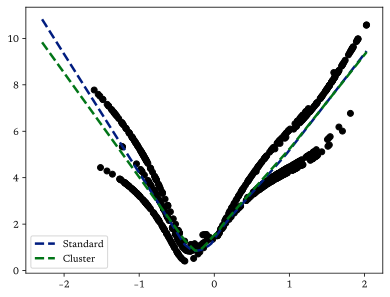

(1000, 1)


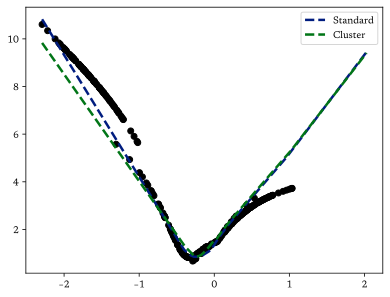

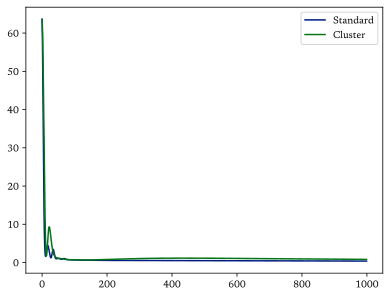

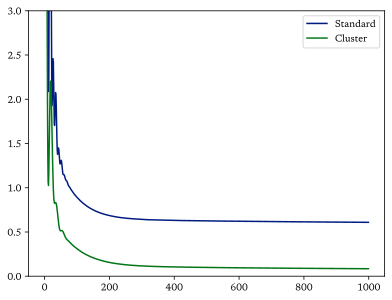

In [12]:

if d == 1:
    kk = 10
    ts, vs, (xss, yss, yhatss, tg) = standard_simulate(jax.random.key(kk), n, c, d)
    tsc, vsc, (xss, yss, yhatsc, tg) = cluster_simulate(jax.random.key(kk), n, c, d)
    print(f"Minimum Validation Loss: Standard --> {jnp.min(vs):.3f} | Cluster -->  {jnp.min(vsc):.3f}")
    print(f"Final Validation Loss: Standard --> {vs[-1]:.3f} | Cluster -->  {vsc[-1]:.3f}")

    ###
    for z, (i, j) in enumerate(zip(xss, yss)):
        if tg[z]:
            idx = jnp.argsort(i[:,0])
            plt.scatter(i[:,0][idx], j[idx], color='black')
    xs = rearrange(xss, 'a b c -> (a b) c').reshape(-1,1)
    print(xs.shape)
    idx = jnp.argsort(xs.reshape(-1,))
    yhats = rearrange(yhatss, 'a b c -> (a b) c')
    yhatc = rearrange(yhatsc, 'a b c -> (a b) c')
    plt.plot(xs[idx], yhats[idx], linestyle='--', label='Standard', linewidth=2.5)
    plt.plot(xs[idx], yhatc[idx], linestyle='--', label='Cluster', linewidth=2.5)
    plt.legend()
    plt.show()

    ###
    for z, (i, j) in enumerate(zip(xss, yss)):
        if not tg[z]:
            idx = jnp.argsort(i[:,0])
            plt.scatter(i[:,0][idx], j[idx], color='black')
    xs = rearrange(xss, 'a b c -> (a b) c')[:,0].reshape(-1,1)
    print(xs.shape)
    idx = jnp.argsort(xs.reshape(-1,))
    yhats = rearrange(yhatss, 'a b c -> (a b) c')
    yhatc = rearrange(yhatsc, 'a b c -> (a b) c')
    plt.plot(xs[idx], yhats[idx], linestyle='--', label='Standard', linewidth=2.5)
    plt.plot(xs[idx], yhatc[idx], linestyle='--', label='Cluster', linewidth=2.5)
    plt.legend()
    plt.show()

    plt.plot(vs, label='Standard')
    plt.plot(vsc, label='Cluster')
    plt.legend()
    plt.show()

    plt.plot(ts, label='Standard')
    plt.plot(tsc, label='Cluster')
    plt.ylim(0,3)
    plt.legend()
    plt.show()

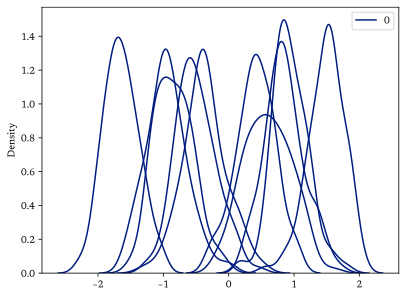

In [13]:
import seaborn as sns

for i in xss:
    sns.kdeplot(i, fill=False)
plt.show()

In [14]:
results = {'standard': {'training_loss': [], 'validation_loss': []},
           'cluster': {'training_loss': [], 'validation_loss': []}}

In [15]:
key = init_key
for _ in tqdm(range(simulations)):
    t, v, _ = standard_simulate(key, n, c, d)
    results['standard']['training_loss'].append(t)
    results['standard']['validation_loss'].append(v)
    key, _ = jax.random.split(key)

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [16]:
key = init_key
for _ in tqdm(range(simulations)):
    t, v, _ = cluster_simulate(key, n, c, d)
    results['cluster']['training_loss'].append(t)
    results['cluster']['validation_loss'].append(v)
    key, _ = jax.random.split(key)

 28%|██▊       | 28/100 [11:13<29:34, 24.64s/it]

In [ ]:
standard_last = jnp.array([i[-1] for i in results['standard']['validation_loss']])
rfp_last = jnp.array([i[-1] for i in results['cluster']['validation_loss']])
print(jnp.mean(standard_last), jnp.mean(rfp_last))            

# Create bar graph
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

subtitle = 'Validation Loss'
ax.text(0., 1.02, s=subtitle, transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot(standard_last/standard_last, label='Standard')
plt.plot(rfp_last/standard_last, label='RFP')
plt.xlabel('Random Seeds', size=14)
plt.legend()
plt.ylim(0, 2)
#fig.savefig(figure_folders + f'naive_exp1_{n}_{c}_{d}_{epochs}_{inner_epochs}.png')
plt.show()

In [ ]:
standard = jnp.array([jnp.min(jnp.array(i)) for i in results['standard']['validation_loss']])
rfp = jnp.array([jnp.min(jnp.array(i)) for i in results['cluster']['validation_loss']])

print(jnp.mean(standard), jnp.mean(rfp))

In [ ]:
# Create bar graph
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

subtitle = 'Validation Loss'
ax.text(0., 1.02, s=subtitle, transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot(standard/standard, label='Standard')
plt.plot(jnp.minimum(rfp/standard, 2.0), label='RFP')
plt.xlabel('Random Seeds', size=14)
plt.legend()
plt.ylim(0, 2)
#fig.savefig(figure_folders + f'naive_exp1_{n}_{c}_{d}_{epochs}_{inner_epochs}.png')
plt.show()

In [ ]:
means = [jnp.mean(standard_last)/jnp.mean(standard_last), jnp.mean(rfp_last)/jnp.mean(standard_last), jnp.mean(standard)/jnp.mean(standard), jnp.mean(rfp)/jnp.mean(standard)]

# Positions of the bars
positions = [-0.2, 0.2, 1.0, 1.4]

# Labels for the x-axis
labels = ['Training Convergence', 'Training Convergence', 'Early Stopping', 'Early Stopping']

# Colors for the bars
colors = ['#36454F', 'purple', '#36454F', 'purple']

# Plotting
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4.5, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Validation Loss', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

bars = ax.bar(positions, means, width=0.4, color=colors)

# Adding labels and title
ax.set_xticks([0, 1.2])
ax.set_xticklabels(['Training Convergence', 'Early Stopping'], size=14)

# Adding custom legend
import matplotlib.patches as mpatches
standard_patch = mpatches.Patch(color='#36454F', label='Standard')
rfp_patch = mpatches.Patch(color='purple', label='RFP')
ax.legend(handles=[standard_patch, rfp_patch], loc='upper right')
plt.ylim(0, 1.2)

plt.show()